In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

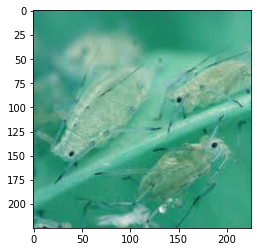

In [2]:
img=cv2.imread('../input/pest-dataset/pest/train/aphids/jpg_0 - Copy (2).jpg')
plt.imshow(img)
plt.show()


In [3]:
img=np.array(img)
img.shape

(225, 225, 3)

In [4]:
train_dir='../input/pest-dataset/pest/train/'
test_dir='../input/pest-dataset/pest/test/'



training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)


Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [5]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17227776/17225924 [==============================] - 0s 0us/step


In [6]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)

In [7]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [8]:
mobilenet.trainable=False

In [9]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [11]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [12]:
history=model.fit(training,validation_data=validing,epochs=20,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/20
10/10 - 12s - loss: 2.2926 - accuracy: 0.3250 - val_loss: 10.2412 - val_accuracy: 0.0625
Epoch 2/20
10/10 - 3s - loss: 1.8164 - accuracy: 0.4966 - val_loss: 10.0444 - val_accuracy: 0.0625
Epoch 3/20
10/10 - 3s - loss: 1.5071 - accuracy: 0.5688 - val_loss: 3.4674 - val_accuracy: 0.4375
Epoch 4/20
10/10 - 3s - loss: 1.1354 - accuracy: 0.7188 - val_loss: 3.3846 - val_accuracy: 0.3750
Epoch 5/20
10/10 - 3s - loss: 1.1847 - accuracy: 0.6875 - val_loss: 5.7003 - val_accuracy: 0.1875
Epoch 6/20
10/10 - 3s - loss: 0.9449 - accuracy: 0.7812 - val_loss: 3.7980 - val_accuracy: 0.2500
Epoch 7/20
10/10 - 3s - loss: 1.2279 - accuracy: 0.7250 - val_loss: 3.1655 - val_accuracy: 0.4375
Epoch 8/20
10/10 - 3s - loss: 0.8218 - accuracy: 0.7250 - val_loss: 1.8163 - val_accuracy: 0.5000
Epoch 9/20
10/10 - 3s - loss: 0.8557 - accuracy: 0.7315 - val_loss: 1.3961 - val_accuracy: 0.6250
Epoch 10/20
10/10 - 3s - loss: 0.8476 - accuracy: 0.7312 - val_loss: 2.6350 - val_accuracy: 0.3125
Epoch 11/20
10/1

In [13]:
loss , acc = model.evaluate(testing)

29/29 [==============================] - 3s 94ms/step - loss: 0.5383 - accuracy: 0.8289


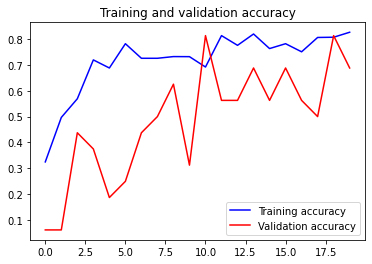

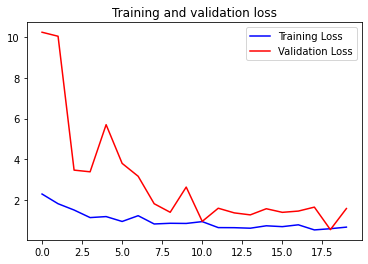

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
import os
working_dir=r'./'
subject='pests' 
save_id= 'Pest.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)